In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from nltk import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer
from utils import Serialization
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tqdm.pandas()
# model = SentenceTransformer("bert-large-nli-mean-tokens")

In [3]:
df1 = pd.read_csv("community_posting_statistics.csv", index_col=0)
df2 = pd.read_csv("community_posting_statistics_2_5_8_11.csv", index_col=0)

df = df1.add(df2, fill_value=0).sort_values(by="body")

In [4]:
cutoffs = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
com_counts = []
for cutoff in cutoffs:
    num_communities = df[df['body'] >= cutoff].shape[0]
    com_counts.append(num_communities)

Text(0.5, 1.0, 'Number of communities with at least n stance marker posts')

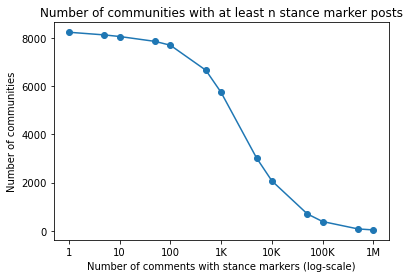

In [5]:
plt.plot(np.log10(cutoffs), com_counts, marker='o')
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels = ["1", "10", "100", "1K", "10K", "100K", "1M"])
plt.xlabel("Number of comments with stance markers (log-scale)")
plt.ylabel("Number of communities")
plt.title("Number of communities with at least n stance marker posts")

Text(0.5, 1.0, 'Number of communities with at least n stance marker posts')

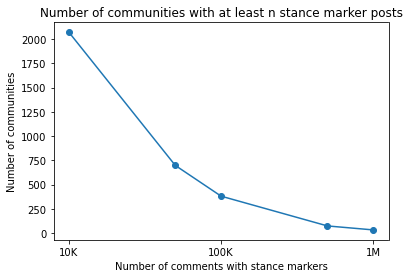

In [6]:
plt.plot(np.log10(cutoffs[-5:]), com_counts[-5:], marker='o')
plt.xticks([4, 5, 6], labels = ["10K", "100K", "1M"])
plt.xlabel("Number of comments with stance markers")
plt.ylabel("Number of communities")
plt.title("Number of communities with at least n stance marker posts")

In [10]:
metadata = pd.read_csv("../../AutismHateSpeech/Data/reddit-master-metadata.tsv", delimiter='\t')
community_embeddings = pd.read_csv("../../AutismHateSpeech/Data/reddit-master-vectors.tsv", delimiter='\t', header=None)
metadata['community'] = metadata['community'].str.lower()
df.index = df.index.str.lower()
top = df[df['body'] >= 100000]
top_5 = top.sample(20, random_state=8)
idx_to_community = metadata['community'].to_dict()
community_to_idx = {idx_to_community[key]:  key for key in idx_to_community}

In [11]:
intersect = metadata[metadata['community'].isin(df.index)]
print("Missing Communities")
differing = set(df.index).difference(intersect['community'])
for d in differing:
    print(f"{d}: {df.loc[d]['body']}")

Missing Communities


In [12]:
all_embeddings = community_embeddings.to_numpy() #.iloc[[community_to_idx[key] for key in df.index.tolist()]]
selected_embeddings = community_embeddings.iloc[[community_to_idx[key] for key in top_5.index.tolist()]].to_numpy()

In [13]:
sims = cosine_similarity(selected_embeddings, all_embeddings)
most_sim = sims.argsort(axis=1)[:, ::-1] #[:, -6:]

In [14]:
final_comm_set = []
for i in range(len(most_sim)):
    row = most_sim[i]
    original = row[0]
    rest = row[1:]
    og_com = idx_to_community[original]
    rest_com = [idx_to_community[key] for key in rest]
    print(f"Original Community: {og_com} with cos_sim {np.round(sims[i][original], 2)}")
    counter = 0
    j = 0
    final_comm_set.append(og_com)
    while counter < 4:
        if rest_com[j] in top.index:
            print(f"Rank {j+1}: {rest_com[j]} with cos_sim {np.round(sims[i][rest[j]], 2)}")
            final_comm_set.append(rest_com[j])
            counter += 1
        j += 1
    
        

Original Community: photoshopbattles with cos_sim 1.0
Rank 2: gifs with cos_sim 0.76
Rank 3: mildlyinteresting with cos_sim 0.75
Rank 5: woahdude with cos_sim 0.73
Rank 18: reactiongifs with cos_sim 0.69
Original Community: seattle with cos_sim 1.0
Rank 8: seahawks with cos_sim 0.69
Rank 22: portland with cos_sim 0.48
Rank 30: mls with cos_sim 0.46
Rank 55: okcupid with cos_sim 0.44
Original Community: buildapc with cos_sim 1.0
Rank 9: hardwareswap with cos_sim 0.73
Rank 10: pcmasterrace with cos_sim 0.72
Rank 13: battlestations with cos_sim 0.71
Rank 14: techsupport with cos_sim 0.7
Original Community: suicidewatch with cos_sim 1.0
Rank 1: depression with cos_sim 0.8
Rank 17: offmychest with cos_sim 0.63
Rank 35: amiugly with cos_sim 0.57
Rank 37: nosleep with cos_sim 0.57
Original Community: fantasybaseball with cos_sim 1.0
Rank 1: baseball with cos_sim 0.74
Rank 3: fantasyfootball with cos_sim 0.7
Rank 19: cardinals with cos_sim 0.57
Rank 25: nfl with cos_sim 0.56
Original Community

In [18]:
freqs = df.loc[set(final_comm_set)]

In [20]:
freqs.sort_values(by='body')

,body
subreddit,
suicidewatch,100201.0
whatisthisthing,100575.0
fantasybaseball,100979.0
photoshopbattles,102144.0
jokes,105201.0
...,...
todayilearned,2613678.0
nfl,2633914.0
videos,2833531.0


In [11]:
freqs.to_csv("test_communities.csv")